## TUTORIAL 12 - Stokes Equations
**_Keywords: geometrical parametrization, POD-Galerkin method, mixed formulation, inf sup condition_**

### 1. Introduction

This tutorial addresses geometrical parametrization and the POD-Galerkin method applied to the steady Stokes equations in a domain $\Omega_o \subset \mathbb{R}^2$ divided into 4 parts with boundary $\Gamma_o$.

![mesh](data/mesh.png)

The problem is characterized by six parameters. We introduce a vector of parameters $\boldsymbol{\mu} = \{t,D,L,S,H,\theta \}$ that control the shape of the subdomains. The ranges of the six parameters are the following:

The parameter vector $\boldsymbol{\mu}$ is thus given by $$\boldsymbol{\mu}=(\mu_0,\mu_1,\mu_2,\mu_3,\mu_4,\mu_5)$$ which corresponds to $\boldsymbol{\mu} = \{t,D,L,S,H,\theta \}$, respectively, on the parameter domain $$\mathbb{P}=[0.5,1.5]\times[0.5,1.5]\times[0.5,1.5]\times[0.5,1.5]\times[0.5,1.5]\times[0,\pi/6]$$

In this program, we apply the following conditions on the boundaries: 
* Zero velocity on the left boundary $\Gamma_{o,w}$ 
* Constant inflow on the right boundary $\Gamma_{o,in}$
* Stress free Neumann condition on the bottom boundary $\Gamma_{o,out}$

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method from a fixed reference domain.



### 2. Parametrized formulation

Let $\boldsymbol{u_o}(\boldsymbol{\mu})$ be the velocity vector and $p_o(\boldsymbol{\mu})$ be the pressure in the domain $\Omega_o(\boldsymbol{\mu})$.

We will directly provide a weak formulation for this problem:
for a given parameter $\boldsymbol{\mu} \in\mathbb{P}$, find $\boldsymbol{u_o}(\boldsymbol{\mu}) \in\mathbb{V_o}(\boldsymbol{\mu})$, $p_o \in\mathbb{M_o}$ such that 

$$
\begin{cases}
    \nu \int_{\Omega_o} \nabla \boldsymbol{u_o} : \nabla \boldsymbol{v_o} \ d\Omega - \int_{\Omega_o} p_o \nabla \cdot \boldsymbol{v_o} \ d\Omega = \int_{\Omega_o} \boldsymbol{f_o} \cdot \boldsymbol{v_o} \ d\Omega, \quad \forall \boldsymbol{v_o} \in\mathbb{V_o},  \\
    \int_{\Omega_o} q_o \nabla \cdot \boldsymbol{u_o} \ d\Omega = 0, \quad \forall q_o \in\mathbb{M_o}
\end{cases}
$$


where

* $\nu$ represents kinematic viscosity
* the functional space $\mathbb{V_o}(\boldsymbol{\mu})$ is defined as $$\mathbb{V_o}(\boldsymbol{\mu}) = [H_{\Gamma_{o,w}}^{1}(\Omega_o)]^2$$
* the functional space $\mathbb{M_o}(\boldsymbol{\mu})$ is defined as $$\mathbb{M_o}(\boldsymbol{\mu}) = L^2(\Omega_o)$$ 
Note that the functional spaces are parameter dependent due to the shape variation.

Since this problem utilizes mixed finite element discretization with the velocity and pressure as solution variables, the inf-sup condition is necessary for the well posedness of this problem. Thus, the supremizer operator $T^{\mu}: \mathbb{M_o}_h \rightarrow \mathbb{V_o}_h$ will be used.


In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
from sampling import LinearlyDependentUniformDistribution
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

In order to obtain an affine decomposition, we recast the problem on a fixed, parameter independent, reference domain $\Omega$. We choose one characterized by $\mu_0=\mu_1=\mu_2=\mu_3=\mu_4=1$ and $\mu_5=0$, which we generate through the generate_mesh notebook provided in the *data* folder. 



In [2]:
@PullBackFormsToReferenceDomain()
@AffineShapeParametrization("data/t_bypass_vertices_mapping.vmp")
class Stokes(StokesProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        StokesProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        up = TrialFunction(V)
        (self.u, self.p) = split(up)
        vq = TestFunction(V)
        (self.v, self.q) = split(vq)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        #
        self.f = Constant((0.0, -10.0))
        self.g = Constant(0.0)

    # Return custom problem name
    def name(self):
        return "Stokes1POD"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_supremizers
    def compute_theta(self, term):
        if term == "a":
            theta_a0 = 1.0
            return (theta_a0, )
        elif term in ("b", "bt"):
            theta_b0 = 1.0
            return (theta_b0, )
        elif term == "f":
            theta_f0 = 1.0
            return (theta_f0, )
        elif term == "g":
            theta_g0 = 1.0
            return (theta_g0, )
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_supremizers
    def assemble_operator(self, term):
        dx = self.dx
        if term == "a":
            u = self.u
            v = self.v
            a0 = inner(grad(u), grad(v)) * dx
            return (a0, )
        elif term == "b":
            u = self.u
            q = self.q
            b0 = - q * div(u) * dx
            return (b0, )
        elif term == "bt":
            p = self.p
            v = self.v
            bt0 = - p * div(v) * dx
            return (bt0, )
        elif term == "f":
            v = self.v
            f0 = inner(self.f, v) * dx
            return (f0, )
        elif term == "g":
            q = self.q
            g0 = self.g * q * dx
            return (g0, )
        elif term == "dirichlet_bc_u":
            bc0 = [DirichletBC(self.V.sub(0), Constant((0.0, 0.0)), self.boundaries, 3)]
            return (bc0, )
        elif term == "inner_product_u":
            u = self.u
            v = self.v
            x0 = inner(grad(u), grad(v)) * dx
            return (x0, )
        elif term == "inner_product_p":
            p = self.p
            q = self.q
            x0 = inner(p, q) * dx
            return (x0, )
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/t_bypass.xml")
subdomains = MeshFunction("size_t", mesh, "data/t_bypass_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/t_bypass_facet_region.xml")

### 4.2. Create Finite Element space (Taylor-Hood P2-P1)

In [4]:
element_u = VectorElement("Lagrange", mesh.ufl_cell(), 2)
element_p = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
element = MixedElement(element_u, element_p)
V = FunctionSpace(mesh, element, components=[["u", "s"], "p"])

### 4.3. Allocate an object of the Stokes class

In [5]:
problem = Stokes(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (0.5, 1.5),
    (0.5, 1.5),
    (0.5, 1.5),
    (0.5, 1.5),
    (0.5, 1.5),
    (0., pi / 6.)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(25)
reduction_method.set_tolerance(1e-6)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100, sampling=LinearlyDependentUniformDistribution())
reduced_problem = reduction_method.offline()

=                 Stokes1POD POD-Galerkin offline phase begins                 =

###################################### 0 #######################################
truth solve for mu = (0.9511864960726752, 1.2151893663724196, 1.0488135039273248, 1.0488135039273248, 0.7848106336275804, 0.31560616568660965)
supremizer solve for mu = (0.9511864960726752, 1.2151893663724196, 1.0488135039273248, 1.0488135039273248, 0.7848106336275804, 0.31560616568660965)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (0.9551168170031032, 0.9236547993389047, 1.0448831829968968, 1.0448831829968968, 1.0763452006610952, 0.33818936676785033)
supremizer solve for mu = (0.9551168170031032, 0.9236547993389047, 1.0448831829968968, 1.0448831829968968, 1.0763452006610952, 0.33818936676785033)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (1.0624127887373076, 1

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$\begin{align*}
L_{PINN}(\Xi_{PINN}; W) &= \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) + B^\top(\boldsymbol{\mu}^{(i)})u^{NN}(\boldsymbol{\mu}^{(i)}; W)  - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2 \\
&\hspace{10ex}+  \left\|B(\boldsymbol{\mu}^{(i)})u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{g}(\boldsymbol{\mu}^{(i)})\right\|_2^2
\end{align*}
$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the stiffness matrix, $\boldsymbol{f}(\boldsymbol{\mu})$ is the vector corresponding to the forcing term for the first equation in the system, $B(\boldsymbol{\mu})$ is the matrix which corresponds to the second equation in the system, and $\boldsymbol{g}(\boldsymbol{\mu})$ is the vector corresponding to the forcing term for the second equation.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...


100%|██████████| 10000/10000 [00:54<00:00, 184.36it/s, Loss(training)=0.00176]


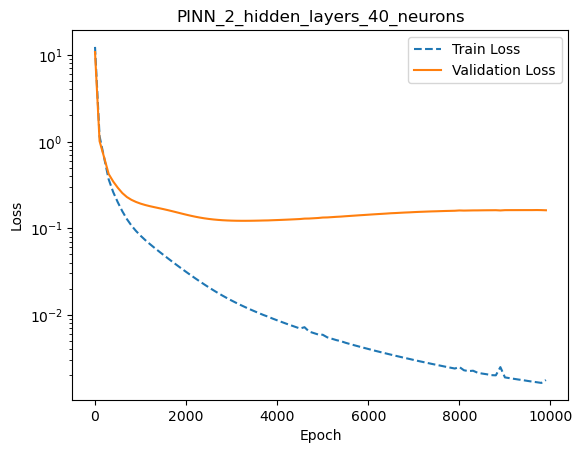

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=3000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

100%|██████████| 3000/3000 [00:03<00:00, 783.56it/s, Loss(training)=0.00974]


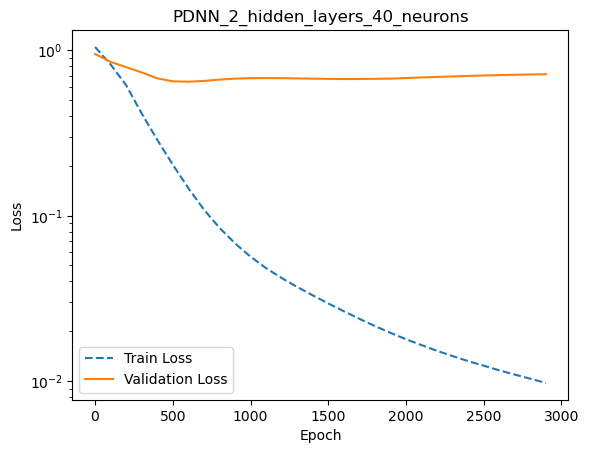

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=40000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

  0%|          | 0/40000 [00:00<?, ?it/s]

Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...
Operator 'bt_restricted' not implemented. Continuing without operator 'bt_restricted'...


100%|██████████| 40000/40000 [02:20<00:00, 284.99it/s, Loss(training)=0.00908]


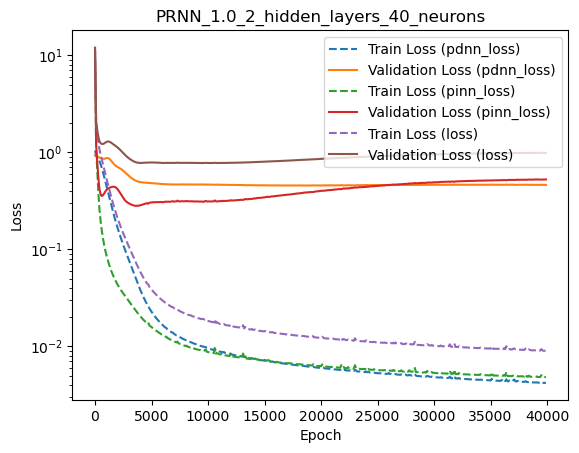

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [17]:
np.random.seed(0)

reduction_method.initialize_testing_set(100, DEIM=60)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0, :])

#### 4.6.2 PINN Error Analysis

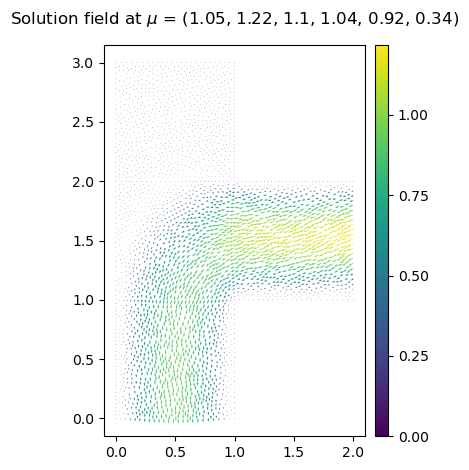

In [18]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn, component="u"
)

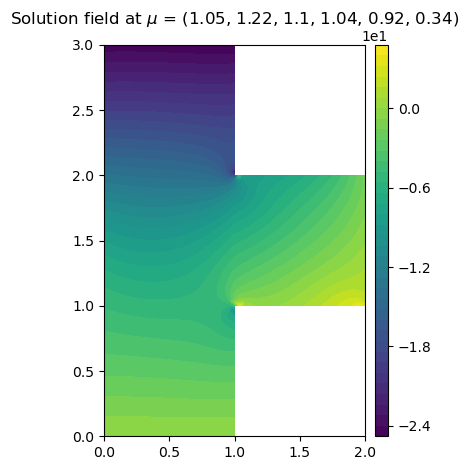

In [19]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn, component="p"
)

In [20]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn, relative=True
)

################################# PINN N = 57 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.003965678997350517	0.0024439588250699746	0.0011122836838775942
mean	0.03183289962750638	0.028489808649169814	0.010797446898639288
max	0.15156982383864753	0.15130182694595712	0.06040720043403491


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


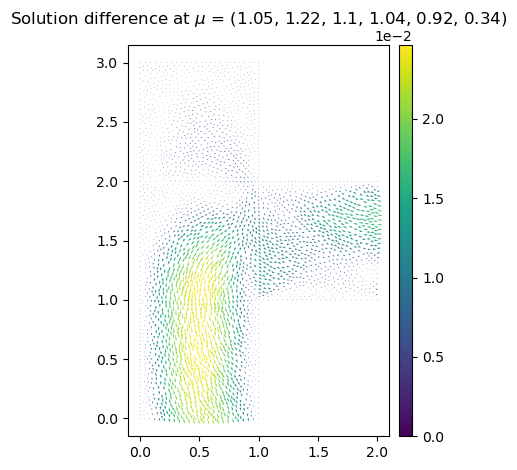

In [21]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn, component="u"
)

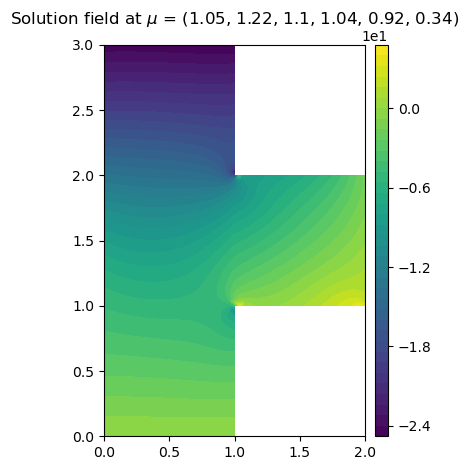

In [22]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn, component="p"
)

#### 4.6.3 PDNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn
)

################################# PDNN N = 57 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.03409592108144712	0.033994681753969136	0.0011122836838775942
mean	0.2601355401990018	0.2589312818253226	0.010797446898639288
max	1.122490074376547	1.1191310132116417	0.06040720043403491


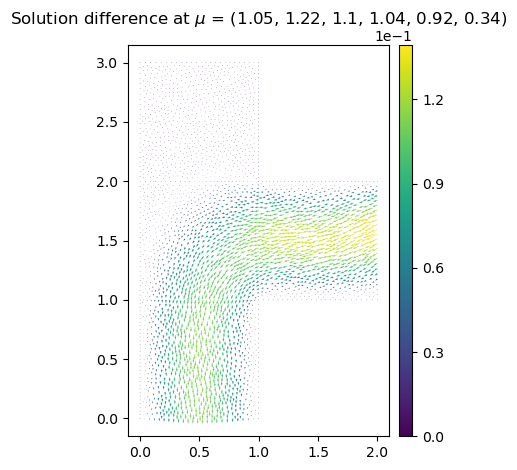

In [24]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn, component="u"
)

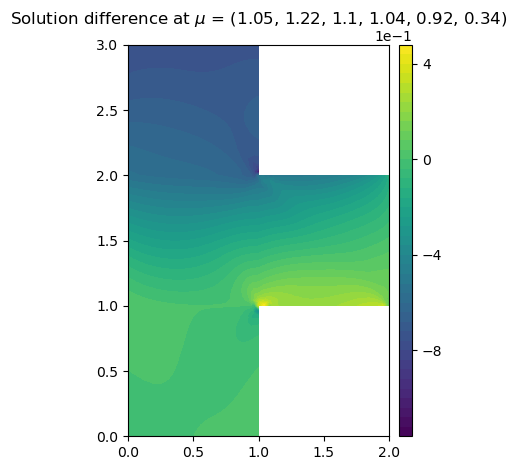

In [25]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn, component="p"
)

#### 4.6.4 PRNN Error Analysis

In [26]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn
)

############################### PRNN_1.0 N = 57 ################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.008475096815019267	0.007408504502526956	0.0011122836838775942
mean	0.0644245823662742	0.06268761115551148	0.010797446898639288
max	0.25375745347291345	0.2546429996729341	0.06040720043403491


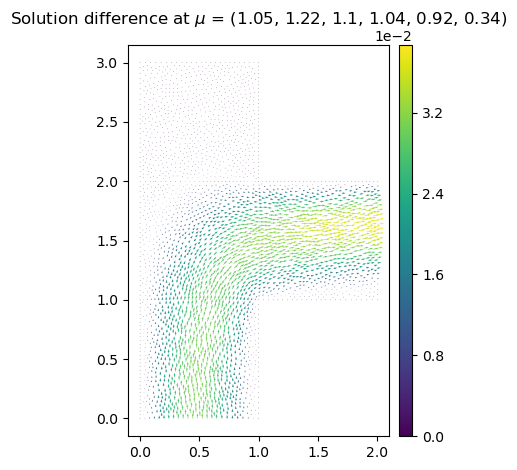

In [27]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn, component="u"
)

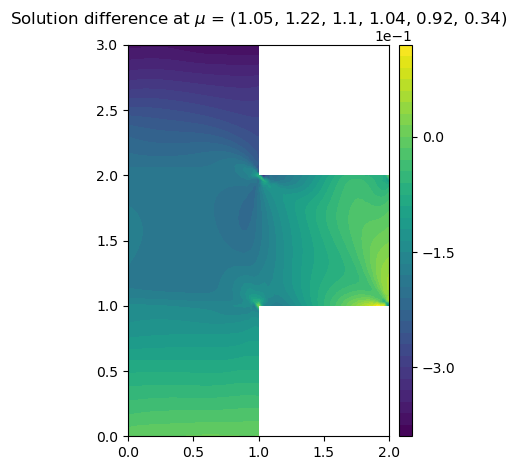

In [28]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn, component="p"
)

#### 4.6.5 Neural Network Error Comparison

In [29]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for N = 57 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.03183289962750638	0.028489808649169814	0.010797446898639288
pdnn_net	0.2601355401990018	0.2589312818253226	0.010797446898639288
prnn_net	0.0644245823662742	0.06268761115551148	0.010797446898639288
#####################################################################################
